In [451]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score

import shap


import numpy as np
import matplotlib.pyplot as plt

In [385]:
mushrooms = pd.read_csv('https://github.com/hsma-programme/h6_4j_model_optimisation/raw/main/exercise/mushrooms.csv', delimiter=';')

In [386]:
mushrooms.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [387]:
mushrooms.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


array([[<Axes: title={'center': 'cap-diameter'}>,
        <Axes: title={'center': 'stem-height'}>],
       [<Axes: title={'center': 'stem-width'}>, <Axes: >]], dtype=object)

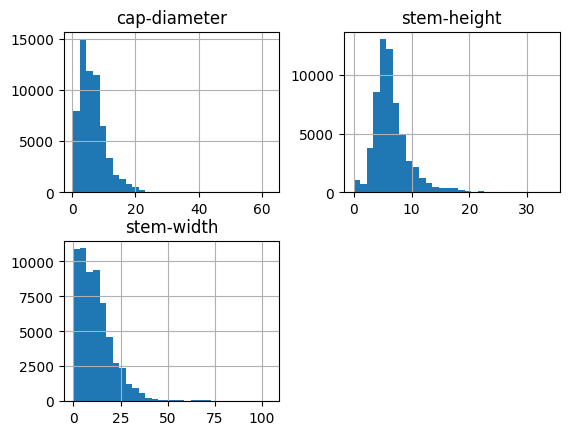

In [388]:
mushrooms.hist(bins=30)

In [389]:
mushrooms["cap-diameter"].value_counts()

3.18     103
3.14      98
3.13      96
3.85      95
3.25      95
        ... 
51.39      1
47.85      1
50.18      1
45.67      1
20.42      1
Name: cap-diameter, Length: 2571, dtype: int64

In [390]:
mushrooms["stem-width"].value_counts()

0.00     1059
2.41       97
2.45       95
2.60       91
2.56       90
         ... 
32.77       1
34.67       1
30.15       1
31.37       1
30.51       1
Name: stem-width, Length: 4630, dtype: int64

In [391]:
mushrooms["stem-height"].value_counts()

0.00     1059
5.24      153
5.92      142
5.32      140
5.99      140
         ... 
27.21       1
27.80       1
24.40       1
26.46       1
24.79       1
Name: stem-height, Length: 2226, dtype: int64

In [392]:
mushrooms.sort_values("stem-height").head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
57818,p,4.11,o,s,r,f,f,f,f,0.0,...,f,f,f,NaN,NaN,t,f,NaN,d,u
56566,p,4.66,o,t,n,f,NaN,c,w,0.0,...,f,f,f,NaN,NaN,f,f,n,d,u
56565,p,4.43,o,s,w,f,NaN,c,w,0.0,...,f,f,f,NaN,NaN,f,f,n,d,u
56564,p,4.21,o,s,n,f,NaN,c,w,0.0,...,f,f,f,NaN,NaN,f,f,n,d,a
56563,p,3.85,o,s,w,f,NaN,c,w,0.0,...,f,f,f,NaN,NaN,f,f,n,d,u


## Dealing with Missing Data

For now, let's just remove examples where stem height and width are missing - assume errors as impossible.

In [393]:
mushrooms_clean = mushrooms[mushrooms['stem-height'] > 0 ]
mushrooms_clean = mushrooms_clean[mushrooms_clean['stem-width'] > 0 ]

### Checking for actual 'NaN' missing values

In [394]:
pd.DataFrame(
    mushrooms_clean.isna().mean().round(4)*100,
    columns=["Percentage of Values Missing"]
    ).sort_values(by="Percentage of Values Missing", ascending=False)

,Percentage of Values Missing
veil-type,94.71
spore-print-color,90.00
veil-color,87.65
stem-root,85.88
stem-surface,63.53
gill-spacing,41.76
cap-surface,23.53
gill-attachment,15.88
ring-type,4.12
class,0.00


Let's just drop the columns with over 25% missing values.

In [395]:
mushrooms_clean.drop(
    columns=['veil-type', 'spore-print-color', 'veil-color', 'stem-root', 'stem-surface', 'gill-spacing'],
    inplace=True
)

## Binary columns

It looks like there are a few columns that are binary. Let's confirm:

In [396]:
mushrooms_clean['does-bruise-or-bleed'].value_counts()

f    49420
t    10590
Name: does-bruise-or-bleed, dtype: int64

In [397]:
mushrooms_clean['has-ring'].value_counts()

f    45184
t    14826
Name: has-ring, dtype: int64

In [398]:
mushrooms_clean['does-bruise-or-bleed'].replace('t', 1, inplace=True)
mushrooms_clean['does-bruise-or-bleed'].replace('f', 0, inplace=True)

mushrooms_clean['has-ring'].replace('t', 1, inplace=True)
mushrooms_clean['has-ring'].replace('f', 0, inplace=True)

In [399]:
mushrooms_clean.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,g,o,0,e,w,16.95,17.09,w,1,g,d,w
1,p,16.60,x,g,o,0,e,w,17.99,18.19,w,1,g,d,u
2,p,14.07,x,g,o,0,e,w,17.80,17.74,w,1,g,d,w
3,p,14.17,f,h,e,0,e,w,15.77,15.98,w,1,p,d,w
4,p,14.64,x,h,o,0,e,w,16.53,17.20,w,1,p,d,w


## Explore Categorical Columns

Let's put the data dictionary here for reference - I've removed the columns we've dropped for now.

#### Numeric
1. cap-diameter (m): float number in cm
9. stem-height (m): float number in cm
10. stem-width (m): float number in mm

#### Binary
5. does-bruise-bleed (n): bruises-or-bleeding=t,no=f

16. has-ring (n): ring=t, none=f



#### Categorical
2. cap-shape (n): bell=b, conical=c, convex=x, flat=f,
sunken=s, spherical=p, others=o

3. cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s,
shiny=h, leathery=l, silky=k, sticky=t,
wrinkled=w, fleshy=e

4. cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p,
purple=u, red=e, white=w, yellow=y, blue=l,
orange=o, black=k

6. gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e,
sinuate=s, pores=p, none=f, unknown=?

8. gill-color (n): see cap-color + none=f

13. stem-color (n): see cap-color + none=f

17. ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g,
large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?

19. habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h,
urban=u, waste=w, woods=d

20. season (n): spring=s, summer=u, autumn=a, winter=w

In [400]:
categorical_columns = ['cap-shape','cap-surface', 'cap-color', 'gill-attachment',
                       'gill-color', 'stem-color', 'ring-type', 'habitat', 'season']

for column in categorical_columns:
    print(column)
    print(mushrooms_clean[column].value_counts(dropna=False))
    print("=================")

cap-shape
x    26934
f    13404
s     7164
b     5694
p     2598
o     2401
c     1815
Name: cap-shape, dtype: int64
cap-surface
NaN    14120
t       8012
s       7086
y       6341
h       4974
g       4724
d       4432
e       2584
k       2303
i       2225
w       2150
l       1059
Name: cap-surface, dtype: int64
cap-color
n    23998
y     8477
w     7473
e     4035
g     3983
o     3577
r     1718
u     1709
p     1703
k     1279
b     1230
l      828
Name: cap-color, dtype: int64
gill-attachment
a      12698
d      10247
NaN     9531
x       7413
p       6001
e       5648
s       5648
f       2824
Name: gill-attachment, dtype: int64
gill-color
w    18168
n     9645
y     9546
p     5983
g     4118
o     2909
f     2824
k     2375
r     1399
e     1066
u     1023
b      954
Name: gill-color, dtype: int64
stem-color
w    22926
n    18063
y     7865
g     2626
o     2187
e     2050
u     1490
p     1025
k      837
r      542
l      226
b      173
Name: stem-color, dtype: int64
ring-ty

## Use data dictionary to make columns easier to interpret.

In [401]:
cap_shape_lookup = {
    'b': 'Bell',
    'c':  'Conical',
    'x': 'Convex',
    'f': 'Flat',
    's': 'Sunken',
    'p': 'Spherical',
    'o':'Others'
}

mushrooms_clean['cap-shape'] = mushrooms_clean['cap-shape'].apply(lambda row_value: cap_shape_lookup.get(row_value))

In [402]:
mushrooms_clean['cap-shape'].value_counts()

Convex       26934
Flat         13404
Sunken        7164
Bell          5694
Spherical     2598
Others        2401
Conical       1815
Name: cap-shape, dtype: int64

In [403]:
cap_surface_lookup =  {
    'i': 'fibrous',
    'g': 'grooves',
    'y':'scaly',
    's': 'smooth',
    'h': 'shiny',
    'l': 'leathery',
    'k': 'silky',
    't': 'sticky',
    'w': 'wrinkled',
    'e': 'fleshy'
    }

mushrooms_clean['cap-surface'] = mushrooms_clean['cap-surface'].apply(
    lambda row_value: cap_surface_lookup.get(row_value)
    )

In [404]:
mushrooms_clean['cap-surface'].value_counts(dropna=False)

sticky      8012
smooth      7086
scaly       6341
shiny       4974
grooves     4724
fleshy      2584
silky       2303
fibrous     2225
wrinkled    2150
leathery    1059
Name: cap-surface, dtype: int64

In [405]:
cap_color_lookup = {
    'n':'brown',
    'b': 'buff',
    'g': 'gray',
    'r': 'green',
    'p': 'pink',
    'u':'purple',
    'e': 'red',
    'w': 'white',
    'y': 'yellow',
    'l': 'blue',
    'o': 'orange',
    'k': 'black',
    'f': 'none'
}

mushrooms_clean['cap-color'] = mushrooms_clean['cap-color'].apply(
    lambda row_value: cap_color_lookup.get(row_value)
    )

In [406]:
mushrooms_clean['cap-color'].value_counts(dropna=False)

brown     23998
yellow     8477
white      7473
red        4035
gray       3983
orange     3577
green      1718
purple     1709
pink       1703
black      1279
buff       1230
blue        828
Name: cap-color, dtype: int64

In [407]:
gill_attachment_lookup = {
    'a': 'adnate',
    'x':'adnexed',
    'd': 'decurrent',
    'e': 'free',
    's': 'sinuate',
    'p': 'pores',
    'f': 'none',
    '?': 'unknown'
}

In [408]:
mushrooms_clean['gill-attachment'] = mushrooms_clean['gill-attachment'].apply(
    lambda row_value: gill_attachment_lookup.get(row_value)
    )

In [409]:
mushrooms_clean['gill-attachment'].value_counts(dropna=False)

adnate       12698
decurrent    10247
None          9531
adnexed       7413
pores         6001
free          5648
sinuate       5648
none          2824
Name: gill-attachment, dtype: int64

In [410]:
mushrooms_clean['gill-color'] = mushrooms_clean['gill-color'].apply(
    lambda row_value: cap_color_lookup.get(row_value)
    )


mushrooms_clean['stem-color'] = mushrooms_clean['stem-color'].apply(
    lambda row_value: cap_color_lookup.get(row_value)
    )

In [411]:
ring_type_lookup = {
    'c': 'cobwebby',
    'e': 'evanescent',
    'r': 'flaring',
    'g': 'grooved',
    'l': 'large',
    'p': 'pendant',
    's': 'sheathing',
    'z': 'zone',
    'y': 'scaly',
    'm': 'movable',
    'f': 'none'
}

mushrooms_clean['ring-type'] = mushrooms_clean['ring-type'].apply(
    lambda row_value: ring_type_lookup.get(row_value)
    )

In [412]:
habitat_lookup = {
    'g': 'grasses',
    'l': 'leaves',
    'm': 'meadows',
    'p': 'paths',
    'h': 'heaths',
    'u': 'urban',
    'w': 'waste',
    'd': 'woods'
}

mushrooms_clean['habitat'] = mushrooms_clean['habitat'].apply(
    lambda row_value: habitat_lookup.get(row_value)
    )

In [413]:
season_lookup = {
    's': 'spring',
    'u': 'summer',
    'a': 'autumn',
    'w': 'winter'

}

mushrooms_clean['season'] = mushrooms_clean['season'].apply(
    lambda row_value: season_lookup.get(row_value)
    )

## Convert Class Column

In [414]:
mushrooms_clean['class'].value_counts()


p    32829
e    27181
Name: class, dtype: int64

In [415]:
mushrooms_clean['class'].replace('p', 1, inplace=True)
mushrooms_clean['class'].replace('e', 0, inplace=True)
mushrooms_clean.rename(columns={'class':'edible'}, inplace=True)

In [416]:
mushrooms_clean['edible'].value_counts(dropna=False)

1    32829
0    27181
Name: edible, dtype: int64

# Imputation

In [439]:
from sklearn.impute import SimpleImputer

def impute_missing_df(df, impute_type="mean"):
    imputed_df = df.copy()
    imputed_df.values[:] = SimpleImputer(missing_values=np.nan, strategy=impute_type).fit_transform(df)
    return imputed_df

In [441]:
mushrooms_clean_imputed = impute_missing_df(mushrooms_clean, impute_type="most_frequent")

## One-Hot Encoding

In [417]:
def create_one_hot(columns, data):
    for column in columns:
    # Create a one-hot encoded representation of the data
        one_hot = pd.get_dummies(data[column], prefix=column).astype('int')

        # Drop the column as it is now encoded
        data = data.drop(column, axis = 1)

        # Join the encoded df
        # As we have not specified, in this case it will join on the only common
        # element of the two dataframes - the index
        data = data.join(one_hot)

    return data

In [442]:
mushrooms_clean_imputed.head()

,edible,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,1,15.26,Convex,grooves,orange,0,free,white,16.95,17.09,white,1,grooved,woods,winter
1,1,16.60,Convex,grooves,orange,0,free,white,17.99,18.19,white,1,grooved,woods,summer
2,1,14.07,Convex,grooves,orange,0,free,white,17.80,17.74,white,1,grooved,woods,winter
3,1,14.17,Flat,shiny,red,0,free,white,15.77,15.98,white,1,pendant,woods,winter
4,1,14.64,Convex,shiny,orange,0,free,white,16.53,17.20,white,1,pendant,woods,winter


In [443]:
columns_to_one_hot_encode = ['cap-shape','cap-surface', 'cap-color', 'gill-attachment',
                             'gill-color', 'stem-color', 'ring-type', 'habitat', 'season']

mushrooms_one_hot = create_one_hot(columns_to_one_hot_encode, mushrooms_clean_imputed)

mushrooms_one_hot

,edible,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,cap-shape_Bell,cap-shape_Conical,cap-shape_Convex,cap-shape_Flat,...,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,season_autumn,season_spring,season_summer,season_winter
0,1,15.26,0,16.95,17.09,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,1,16.60,0,17.99,18.19,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,1,14.07,0,17.80,17.74,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1,14.17,0,15.77,15.98,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,1,14.64,0,16.53,17.20,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,1,1.18,0,3.93,6.22,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
61065,1,1.27,0,3.18,5.43,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
61066,1,1.27,0,3.86,6.37,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
61067,1,1.24,0,3.56,5.44,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


# Splitting and prepping

In [444]:
mushrooms_one_hot.head()

,edible,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,cap-shape_Bell,cap-shape_Conical,cap-shape_Convex,cap-shape_Flat,...,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,season_autumn,season_spring,season_summer,season_winter
0,1,15.26,0,16.95,17.09,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,1,16.60,0,17.99,18.19,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,1,14.07,0,17.80,17.74,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1,14.17,0,15.77,15.98,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,1,14.64,0,16.53,17.20,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [445]:
X = mushrooms_one_hot.drop(columns='edible')
y = mushrooms_one_hot['edible']

feature_names = X.columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 38406
Validation Dataset Samples: 9602
Testing Dataset Samples: 12002


In [446]:
def fit_train(name="XGBoost",
              X_train=X_train, X_validate=X_validate,
              y_train=y_train, y_validate=y_validate,
              model=XGBClassifier(random_state=42)
              ):

     model.fit(X_train, y_train)

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)

     tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

     return pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "FP": fp,
            "FN": fn
          }, index=[name]
).round(3)

In [447]:
fit_train(model=DecisionTreeClassifier(), name="Decision Tree")

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Decision Tree,1.0,0.996,0.996,0.996,0.996,0.996,17,19


In [448]:
fit_train(model=RandomForestClassifier(random_state=42), name="Random Forest")

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Random Forest,1.0,1.0,1.0,1.0,1.0,1.0,3,0


In [449]:
fit_train(model=XGBClassifier(random_state=42))

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
XGBoost,1.0,0.999,0.999,0.999,0.999,0.999,5,8


Let's also compare the performance with using catboost without the one-hot encoding.

In [450]:
fit_train(
    model=VotingClassifier([('xgboost', XGBClassifier(random_state=42)),
                            ('RandomForest', RandomForestClassifier(random_state=42)),
                            ('DecisionTree', DecisionTreeClassifier(random_state=42))
    ], voting="hard"),
    name="Voting Ensemble - Hard"
)

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Voting Ensemble - Hard,1.0,0.999,0.999,0.999,0.999,0.999,2,3


In [427]:
fit_train(
    model=VotingClassifier([('xgboost', XGBClassifier(random_state=42)),
                            ('RandomForest', RandomForestClassifier(random_state=42)),
                            ('DecisionTree', DecisionTreeClassifier(random_state=42))
    ], voting="soft"),
    name="Voting Ensemble - Soft"
)

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Voting Ensemble - Soft,1.0,0.999,0.999,0.999,0.999,0.999,5,4


In [428]:
X_cat = mushrooms_clean.drop(columns='edible')
y_cat = mushrooms_clean['edible']
X_cat.fillna('missing', inplace=True)
feature_names_cat = X_cat.columns.tolist()

X_train_val_cat, X_test_cat, y_train_val_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.2, random_state=42
    )
X_train_cat, X_validate_cat, y_train_cat, y_validate_cat = train_test_split(
    X_train_val_cat, y_train_val_cat, test_size=0.2, random_state=42
    )

fit_train(model=CatBoostClassifier(verbose=False, cat_features=columns_to_one_hot_encode, nan_mode='Min'),
          name="Catboost",
          X_train=X_train_cat,
          y_train=y_train_cat,
          X_validate=X_validate_cat,
          y_validate=y_validate_cat
          )

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Catboost,1.0,0.999,0.999,0.999,0.999,0.999,5,1


#### Check out XGBoost's experimental support for categorical data

Convert categorical columns to the 'category' datatype.

In [457]:
for feature in columns_to_one_hot_encode:
    X_train_cat[feature] = X_train_cat[feature].astype("category")
    X_validate_cat[feature] = X_validate_cat[feature].astype("category")

In [464]:
X_train_cat.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
56918,11.07,Flat,fleshy,buff,0,missing,buff,5.22,21.16,white,1,none,woods,autumn
48336,7.06,Convex,fibrous,yellow,0,adnate,brown,6.53,6.89,brown,1,zone,woods,summer
47219,1.33,Convex,missing,brown,0,missing,black,4.71,2.46,brown,0,none,grasses,summer
31596,6.52,Convex,scaly,brown,0,free,pink,4.68,9.91,brown,0,none,woods,autumn
48373,17.94,Spherical,wrinkled,brown,0,pores,yellow,17.57,73.62,brown,0,none,woods,autumn


Check we have a new enough version of XGBoost (1.6+) to use the experimental support for categorical features.

In [461]:
import xgboost
xgboost.__version__

'2.0.3'

In [463]:
fit_train(model=XGBClassifier(enable_categorical=True),
          name="XGBoost - categorical",
          X_train=X_train_cat,
          y_train=y_train_cat,
          X_validate=X_validate_cat,
          y_validate=y_validate_cat
          )

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
XGBoost - categorical,1.0,1.0,1.0,1.0,1.0,1.0,2,0


Compare this to performance on one-hot encoded data.

In [475]:
fit_train(model=XGBClassifier(random_state=42))

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
XGBoost,1.0,0.999,0.999,0.999,0.999,0.999,5,8


### Plot confusion matrix for best model

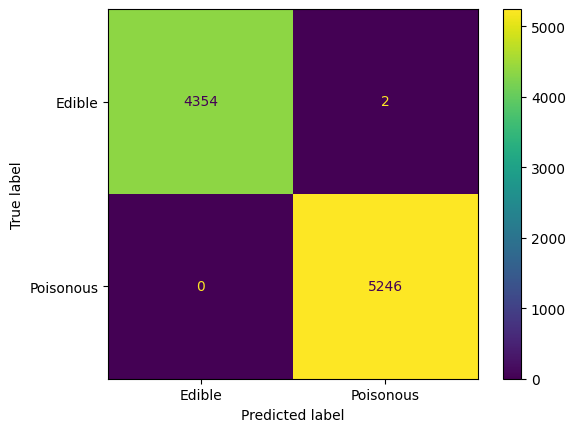

In [466]:
model = XGBClassifier(enable_categorical=True)

model.fit(X_train_cat, y_train_cat)
y_pred_train = model.predict(X_train_cat)
y_pred_val = model.predict(X_validate_cat)

confusion_matrix_mushrooms = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_validate,
        y_pred=y_pred_val
        ),
        display_labels=["Edible", "Poisonous"]
)

confusion_matrix_mushrooms.plot()

# Feature Importance

In [470]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [473]:
feature_importances_mdi_rf = model_rf.feature_importances_

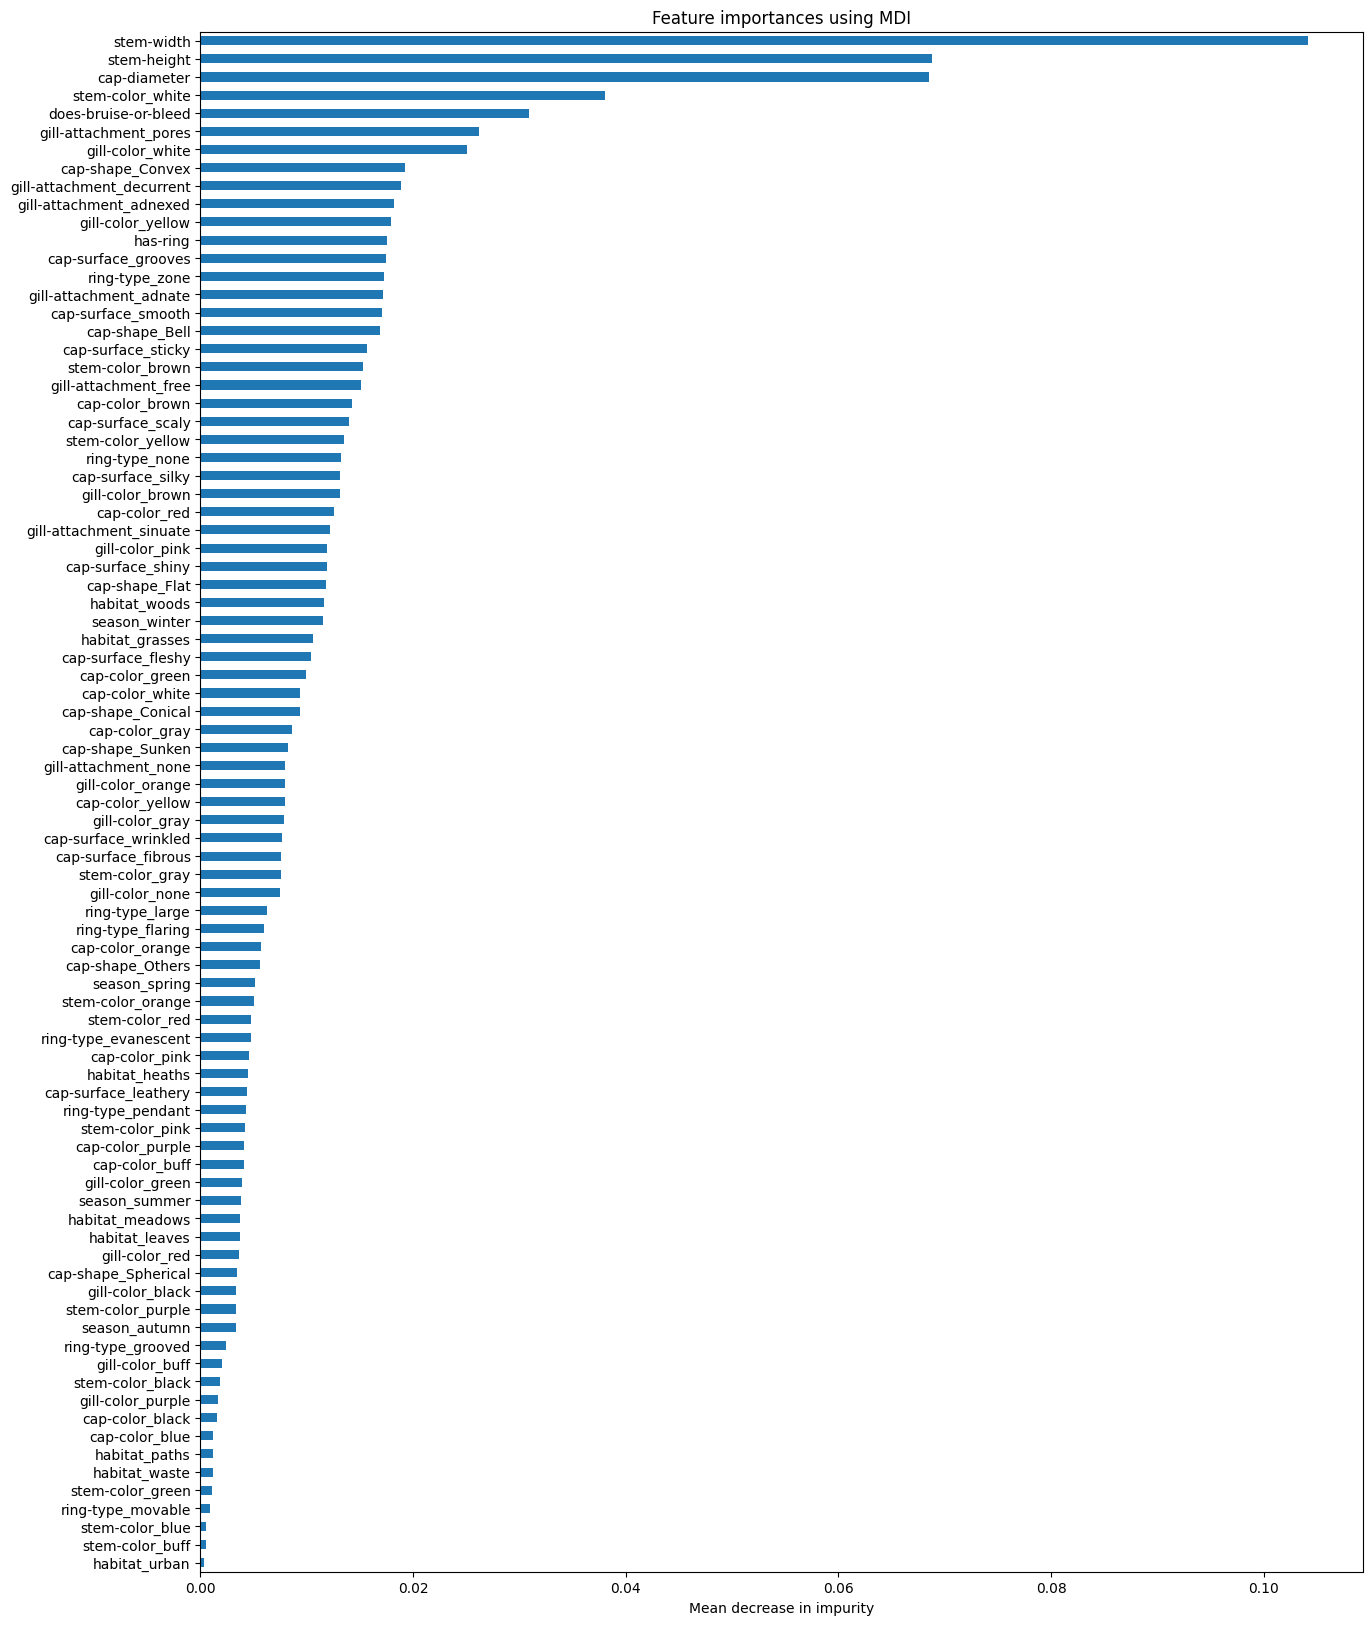

In [474]:
feature_importances_mdi_rf = pd.Series(feature_importances_mdi_rf,
                                    index=feature_names)

fig, ax = plt.subplots(figsize=(15,20))
feature_importances_mdi_rf.sort_values().plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
plt.show()

Let's explore the same thing with catboost (which would be similar to the XGBoost output with categorical data processing enabled.).

In [433]:
catboost_model = CatBoostClassifier(verbose=False, cat_features=columns_to_one_hot_encode, nan_mode='Min')
catboost_model.fit(X_train_cat, y_train_cat)

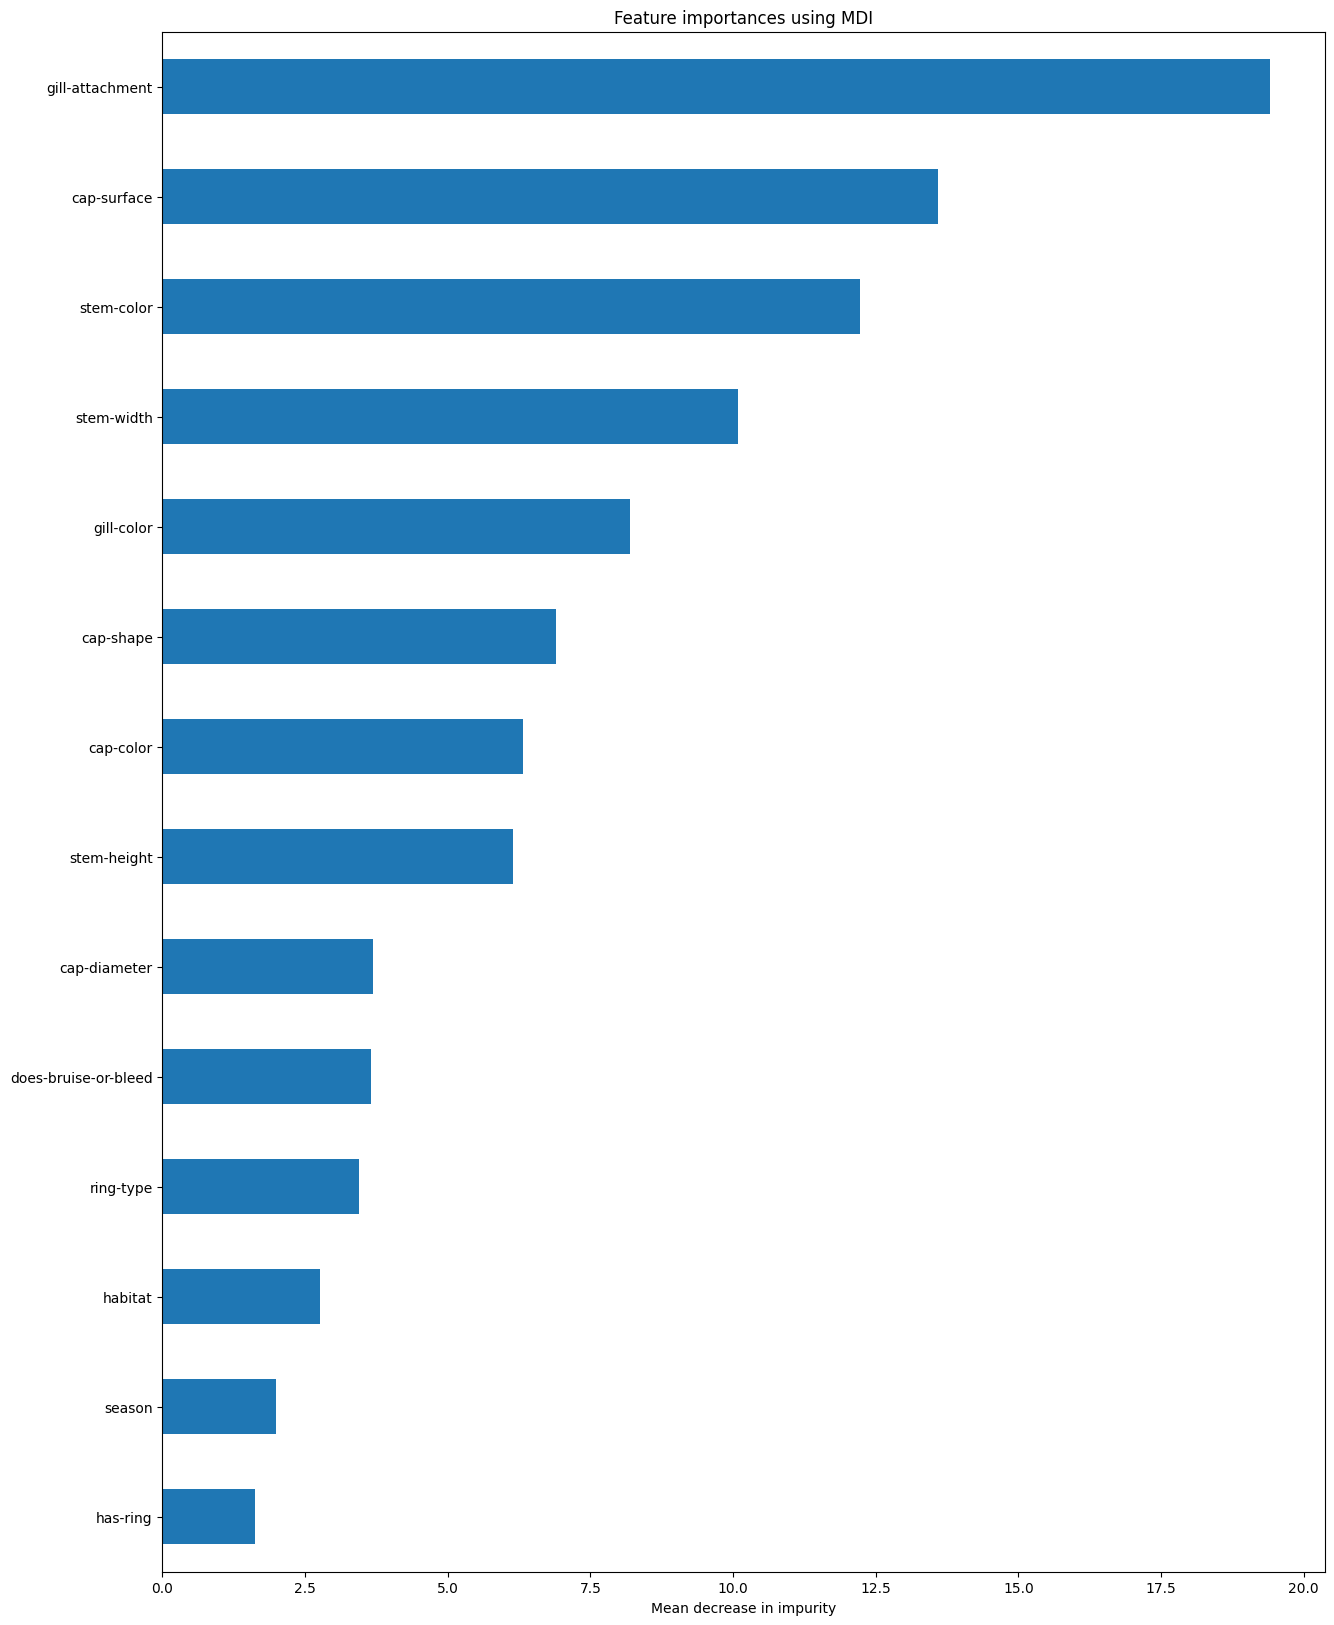

In [434]:
feature_importances_mdi = pd.Series(catboost_model.feature_importances_,
                                    index=X_train_cat.columns.tolist())

fig, ax = plt.subplots(figsize=(15,20))
feature_importances_mdi.sort_values().plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
plt.show()

# Forward Feature Selection

In [435]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select=3, direction="forward"
)

sfs_forward.fit(X_train, y_train)

feature_names_selected_ff = np.array(feature_names)[sfs_forward.get_support()]

print(
    "Features selected by forward sequential selection: "
    f"{feature_names_selected_ff}"
)

fit_train(X_train=X_train[feature_names_selected_ff],
          X_validate=X_validate[feature_names_selected_ff],
          y_train=y_train,
          y_validate=y_validate,
          name="Forward Feature Selection - 3")


KeyboardInterrupt: 

It looks like there isn't a single feature that's entirely responsible for the performance of the model - it looks like it's the collaborative action of several features. 

## Let's repeat with catboost

In [ ]:
from sklearn.feature_selection import SelectFromModel

feature_names_catboost = X_train_cat.columns.tolist()

selector = SelectFromModel(
    estimator=catboost_model,
    threshold=5
    )

selector.fit(X_train_cat, y_train_cat)

feature_names_selected_ff = np.array(feature_names_catboost)[selector.get_support()]

print(
    "Features selected by forward sequential selection: "
    f"{feature_names_selected_ff}"
)

Features selected by forward sequential selection: ['cap-shape' 'cap-surface' 'cap-color' 'gill-attachment' 'gill-color'
 'stem-height' 'stem-width' 'stem-color']


In [ ]:
fit_train(X_train=X_train_cat[feature_names_selected_ff],
          X_validate=X_validate_cat[feature_names_selected_ff],
          y_train=y_train_cat,
          y_validate=y_validate_cat,
          model=CatBoostClassifier(verbose=False, cat_features=[x for x in columns_to_one_hot_encode if x in feature_names_selected_ff], nan_mode='Min'),
          name=f"Forward Feature Selection Catboost - {len(feature_names_selected_ff)} of {len(feature_names_cat)}")


,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Forward Feature Selection Catboost - 8 of 14,0.999,0.999,0.999,0.999,0.999,0.999,8,4


# SHAP

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

explainer = shap.Explainer(model, shap.utils.sample(X_train, 300))
shap_values = explainer(shap.utils.sample(X_validate,300), check_additivity=False)

 94%|=================== | 566/600 [00:13<00:00]       

In [ ]:
shap_values

.values =
array([[[ 0.04883908, -0.04883908],
        [ 0.01425258, -0.01425258],
        [ 0.03072521, -0.03072521],
        ...,
        [-0.00126853,  0.00126853],
        [-0.00284888,  0.00284888],
        [-0.00242874,  0.00242874]],

       [[-0.04231225,  0.04231225],
        [ 0.00558418, -0.00558418],
        [-0.00021219,  0.00021219],
        ...,
        [-0.00260769,  0.00260769],
        [-0.00272087,  0.00272087],
        [-0.00330799,  0.00330799]],

       [[ 0.02338864, -0.02338864],
        [ 0.01594627, -0.01594627],
        [ 0.01699937, -0.01699937],
        ...,
        [-0.00162202,  0.00162202],
        [ 0.00303146, -0.00303146],
        [ 0.06295235, -0.06295236]],

       ...,

       [[-0.0213572 ,  0.0213572 ],
        [-0.11993262,  0.11993262],
        [-0.00743883,  0.00743883],
        ...,
        [-0.00234937,  0.00234937],
        [-0.00674893,  0.00674893],
        [-0.00732369,  0.00732369]],

       [[ 0.01380553, -0.01380553],
        [ 0.00568

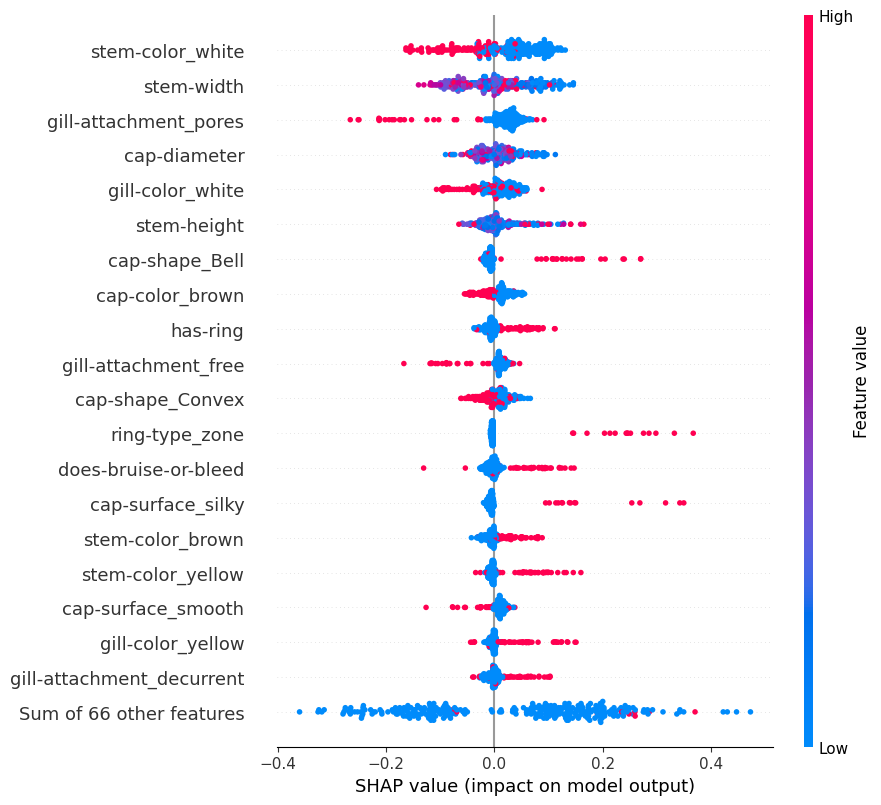

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

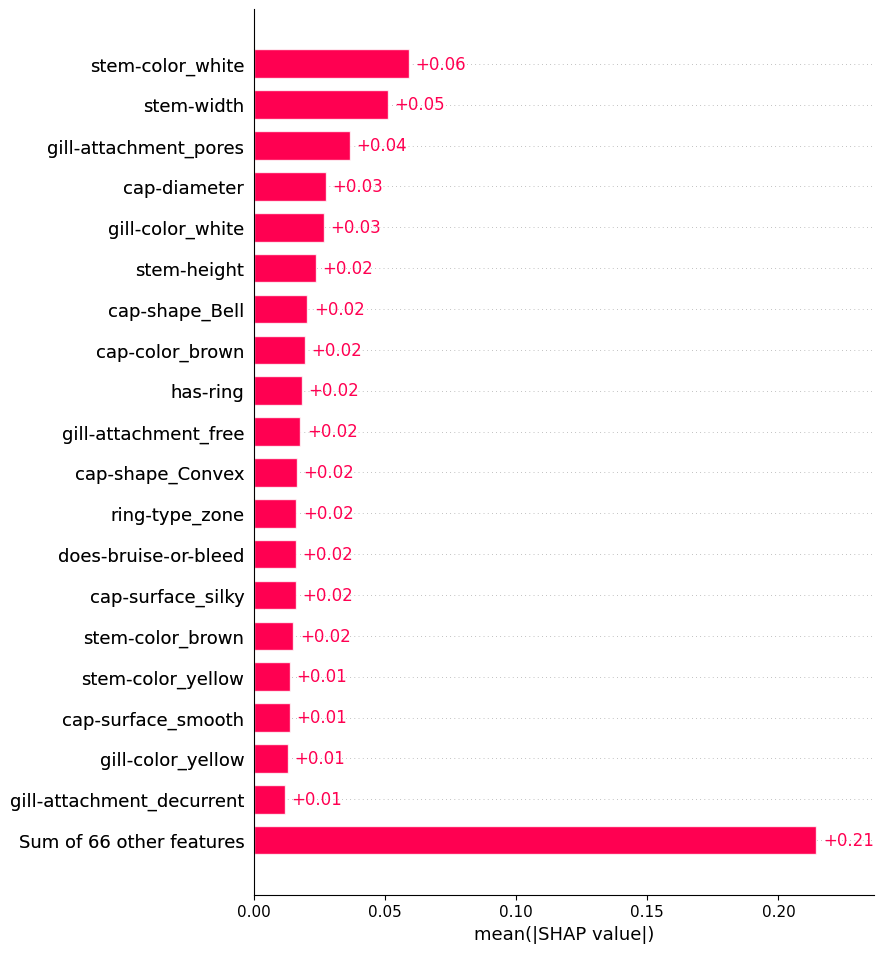

In [ ]:
shap.plots.bar(shap_values[:,:,1], max_display=20)

### Example with very low chance of being poisonous

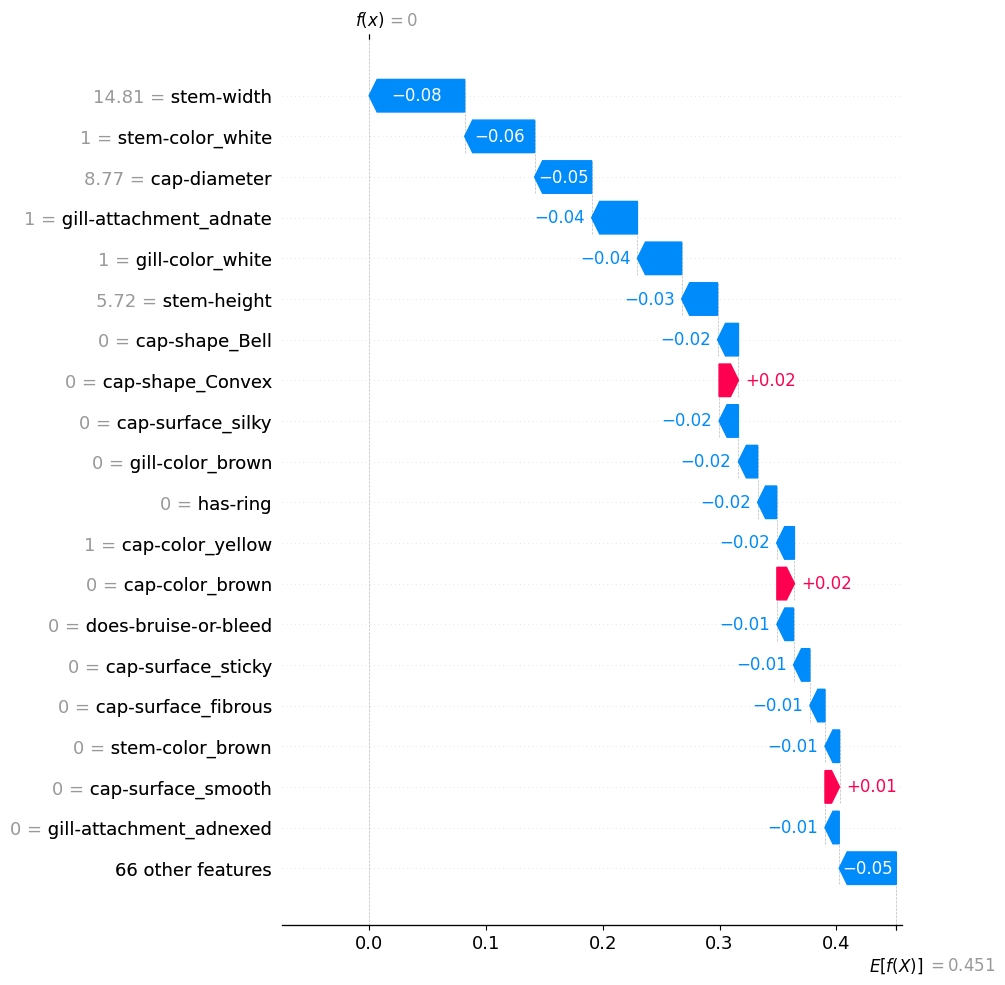

In [ ]:
shap.plots.waterfall(shap_values[:,:,1][0], max_display=20)

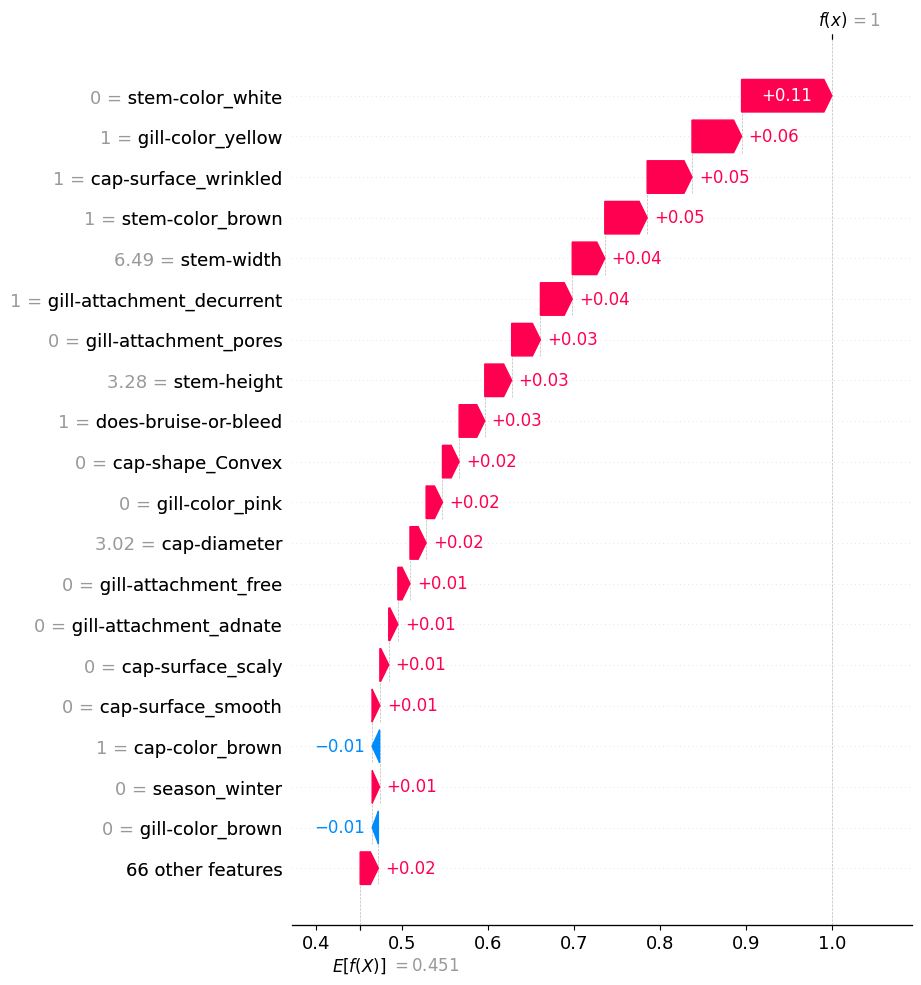

In [ ]:
shap.plots.waterfall(shap_values[:,:,1][15], max_display=20)

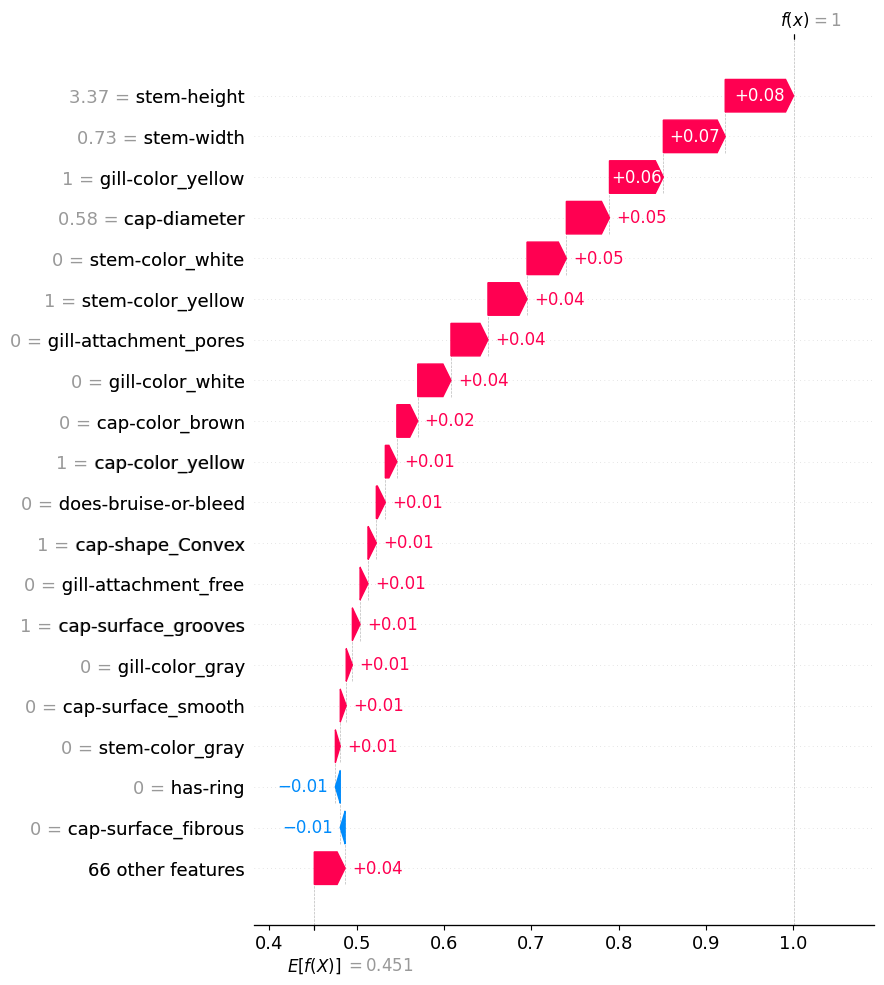

In [ ]:
shap.plots.waterfall(shap_values[:,:,1][205], max_display=20)

## SHAP with catboost

In [ ]:
explainer = shap.Explainer(catboost_model, feature_perturbation="tree_path_dependent")
shap_values = explainer(shap.utils.sample(X_validate_cat,300), check_additivity=False)

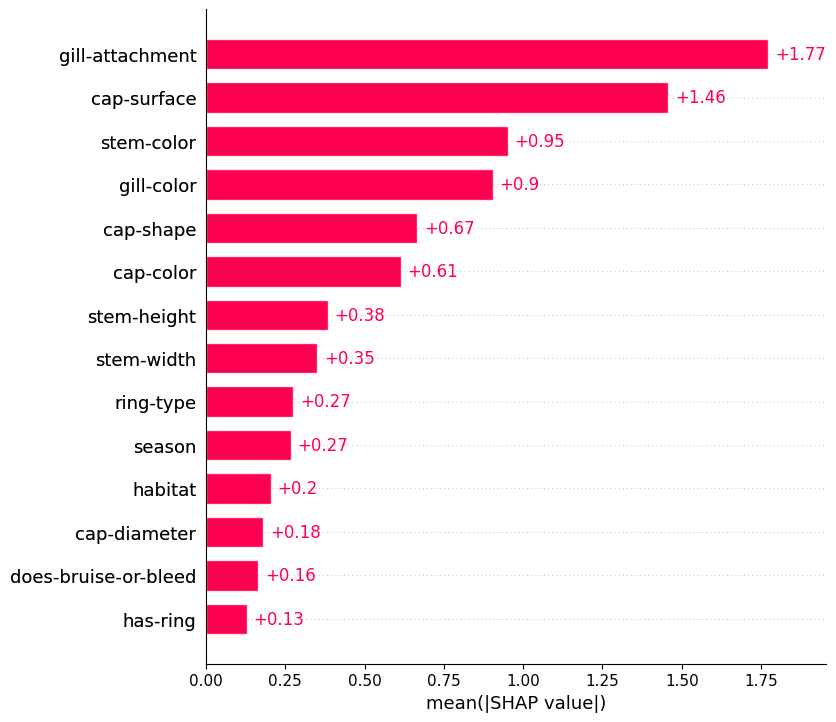

In [ ]:
shap.plots.bar(shap_values, max_display=20)

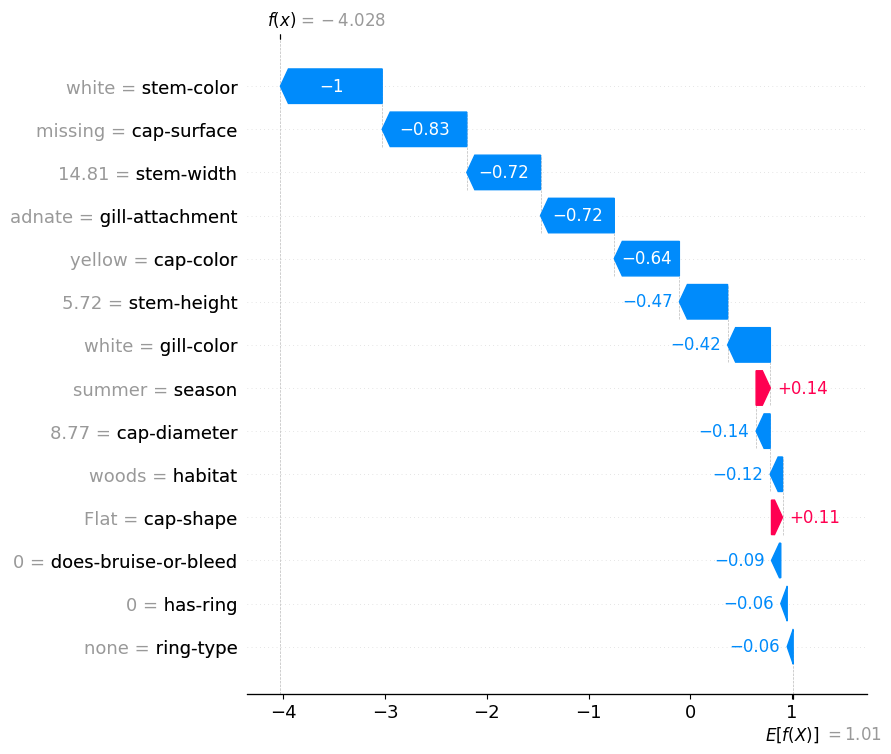

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=20)

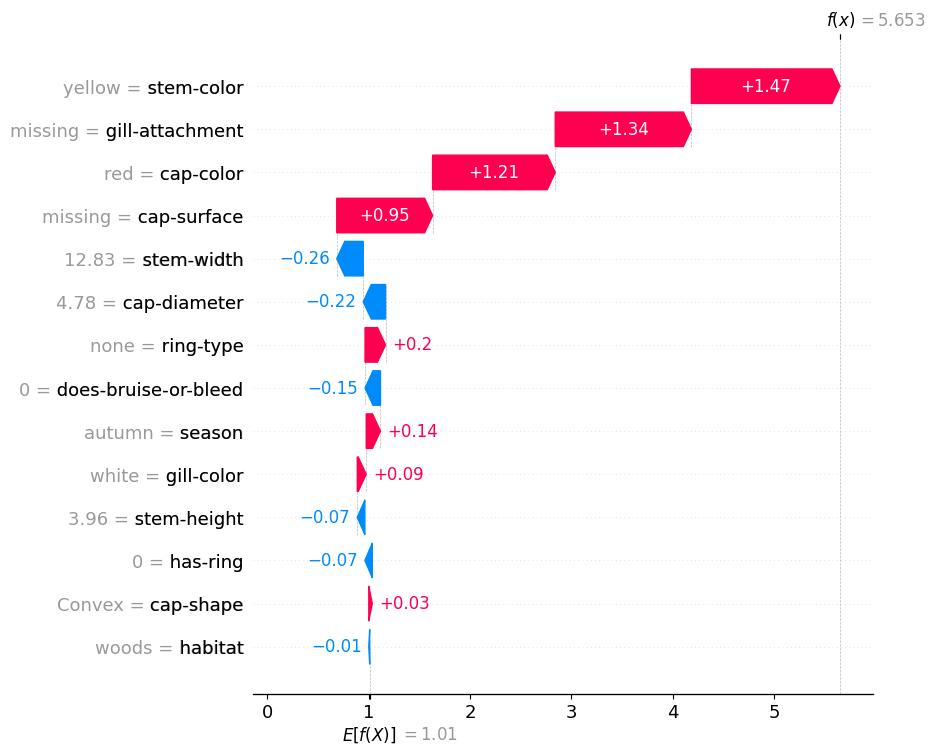

In [ ]:
shap.plots.waterfall(shap_values[35], max_display=20)